In [1]:
import json 
import requests
from keras.models import Sequential 
from keras.layers import Activation, Dense, Dropout, LSTM 
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import seaborn as sns 
from sklearn.metrics import mean_absolute_error
sns.set_palette('Set2')
%matplotlib inline

Using TensorFlow backend.


In [2]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday' 
res = requests.get(endpoint + '?fsym=BTC&tsym=USD&limit=2000') 
hist = pd.DataFrame(json.loads(res.content)['Data']) 
hist = hist.set_index('time') 
hist.index = pd.to_datetime(hist.index, unit='s') 

In [3]:
hist.head() 

,close,high,low,open,volumefrom,volumeto
time,,,,,,
2013-05-26,133.50,136.00,130.61,131.99,23359.36,3130389.06
2013-05-27,129.77,135.47,124.00,133.50,46825.54,6056707.00
2013-05-28,129.00,130.63,125.40,129.77,22803.35,2918762.17
2013-05-29,132.25,132.72,127.60,129.00,19247.65,2509796.39
2013-05-30,128.80,132.40,126.50,132.25,24699.41,3195601.21


In [4]:
target_col = 'close' 

In [5]:
def train_test_split(df, test_size=0.1): 
    split_row = int(len(df) - (test_size * len(df))) 
    train_data = df.iloc[:split_row] 
    test_data = df.iloc[split_row:] 
    return train_data, test_data 

In [6]:
train, test = train_test_split(hist, test_size=0.1)

In [7]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2): 
    fig, ax = plt.subplots(1, figsize=(16, 9)) 
    ax.plot(line1, label=label1, linewidth=lw) 
    ax.plot(line2, label=label2, linewidth=lw) 
    ax.set_ylabel('price [USD]', fontsize=14) 
    ax.set_title(title, fontsize=18) 
    ax.legend(loc='best', fontsize=18);

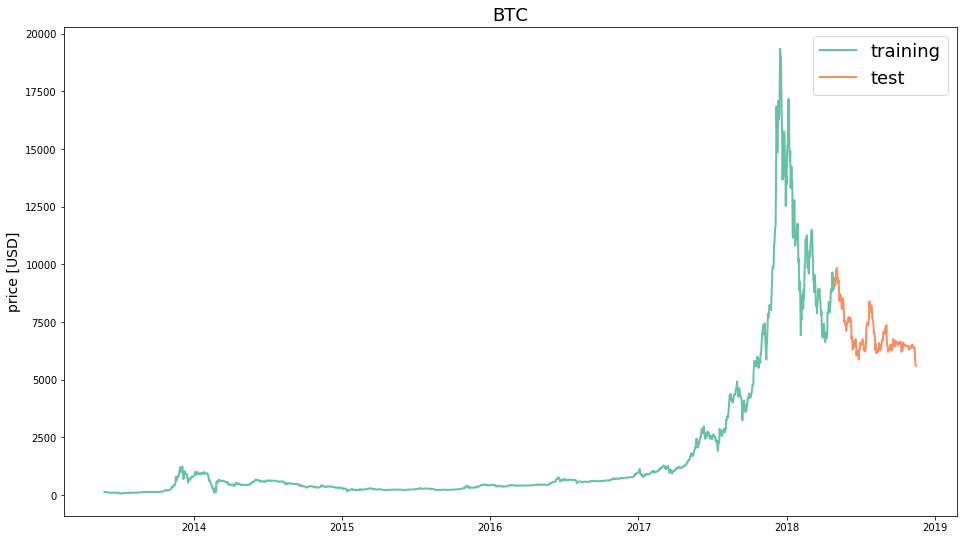

In [8]:
line_plot(train[target_col], test[target_col], 'training', 'test', title='BTC')

In [9]:
 def normalise_zero_base(df): 
        """ Normalise dataframe column-wise to reflect changes with respect to first entry. """ 
        return df / df.iloc[0] - 1

In [10]:
def normalise_min_max(df): 
    """ Normalise dataframe column-wise min/max. """ 
    return (df - df.min()) / (data.max() - df.min())


In [11]:
 def extract_window_data(df, window_len=10, zero_base=True): 
        window_data = [] 
        for idx in range(len(df) - window_len):
            tmp = df[idx: (idx + window_len)].copy() 
            if zero_base: 
                tmp = normalise_zero_base(tmp) 
                window_data.append(tmp.values) 
        return np.array(window_data)

In [12]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2): 
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base) 
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values 
    y_test = test_data[target_col][window_len:].values 
    if zero_base: 
        y_train = y_train / train_data[target_col][:-window_len].values - 1 
        y_test = y_test / test_data[target_col][:-window_len].values - 1
    return train_data, test_data, X_train, X_test, y_train, y_test

In [19]:
def build_lstm_model(input_data, output_size, neurons=20, activ_func='tanh', dropout=0.25, loss='mae', optimizer='adam'): 
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout)) 
    model.add(Dense(units=output_size)) 
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer) 
    return model

In [15]:
np.random.seed(42)
# data params 
window_len = 7 
test_size = 0.1 
zero_base = True
# model params 
lstm_neurons = 20 
epochs = 50 
batch_size = 4 
loss = 'mae' 
dropout = 0.25 
optimizer = 'adam'

In [16]:
train, test, X_train, X_test, y_train, y_test = prepare_data(hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)


In [17]:
X_train.shape


(1793, 7, 6)

In [20]:
model = build_lstm_model(X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss, optimizer=optimizer)
history = model.fit( X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/50
1793/1793 [==============================] - 5s 3ms/step - loss: 0.0675
Epoch 2/50
1793/1793 [==============================] - 3s 2ms/step - loss: 0.0519
Epoch 3/50
1793/1793 [==============================] - 3s 2ms/step - loss: 0.0471
Epoch 4/50
1793/1793 [==============================] - 3s 2ms/step - loss: 0.0456
Epoch 5/50
1793/1793 [==============================] - 3s 2ms/step - loss: 0.0447
Epoch 6/50
1793/1793 [==============================] - 3s 2ms/step - loss: 0.0445
Epoch 7/50
1793/1793 [==============================] - 3s 2ms/step - loss: 0.0435
Epoch 8/50
1793/1793 [==============================] - 3s 2ms/step - loss: 0.0424
Epoch 9/50
1793/1793 [==============================] - 3s 2ms/step - loss: 0.0427
Epoch 10/50
1793/1793 [==============================] - 3s 2ms/step - loss: 0.0410
Epoch 11/50
1793/1793 [==============================] - 3s 2ms/step - loss: 0.0422
Epoch 12/50
1793/1793 [==============================] - 3s 2ms/step - loss: 0.0418
E

In [21]:
targets = test[target_col][window_len:] 
preds = model.predict(X_test).squeeze() 

In [22]:
mean_absolute_error(preds, y_test) 

0.019560152335699528

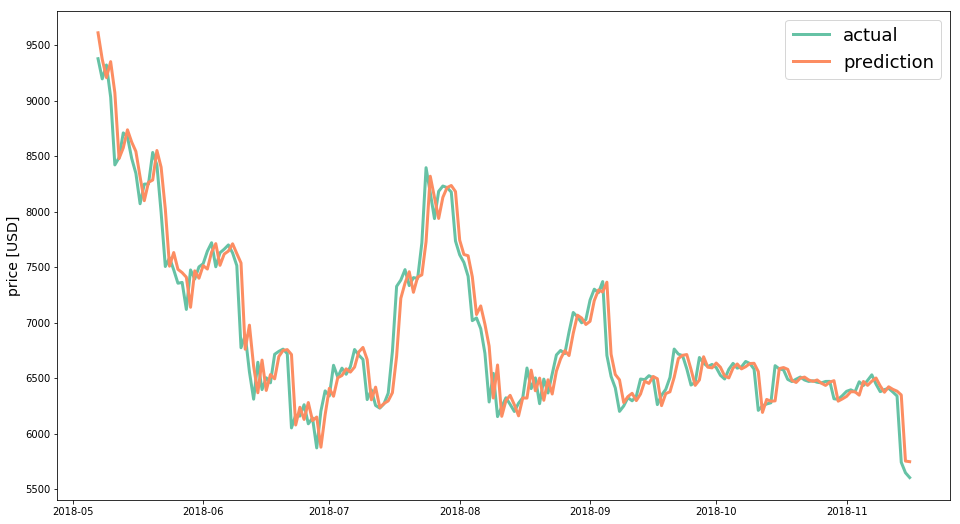

In [23]:
preds = test[target_col].values[:-window_len] * (preds + 1) 
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)

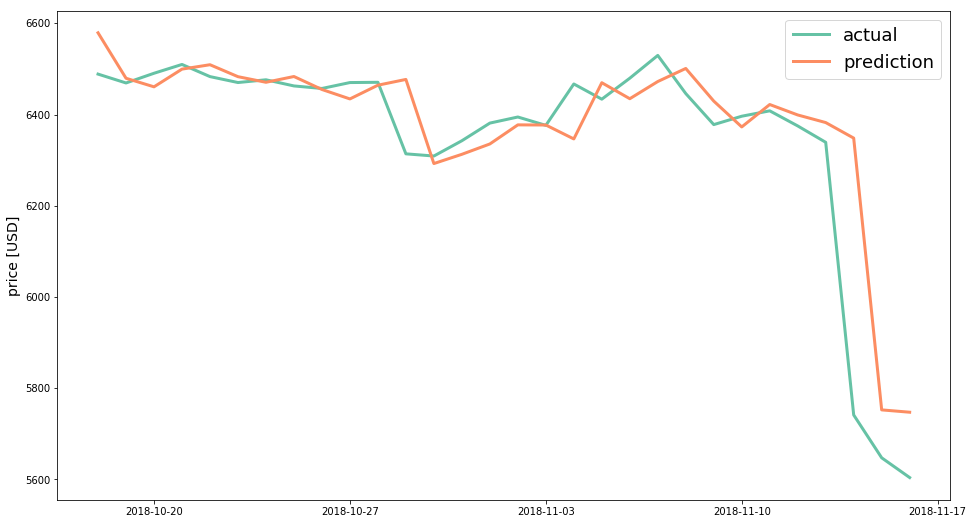

In [24]:
n_points = 30
line_plot(targets[-n_points:], preds[-n_points:], 'actual', 'prediction', lw=3)

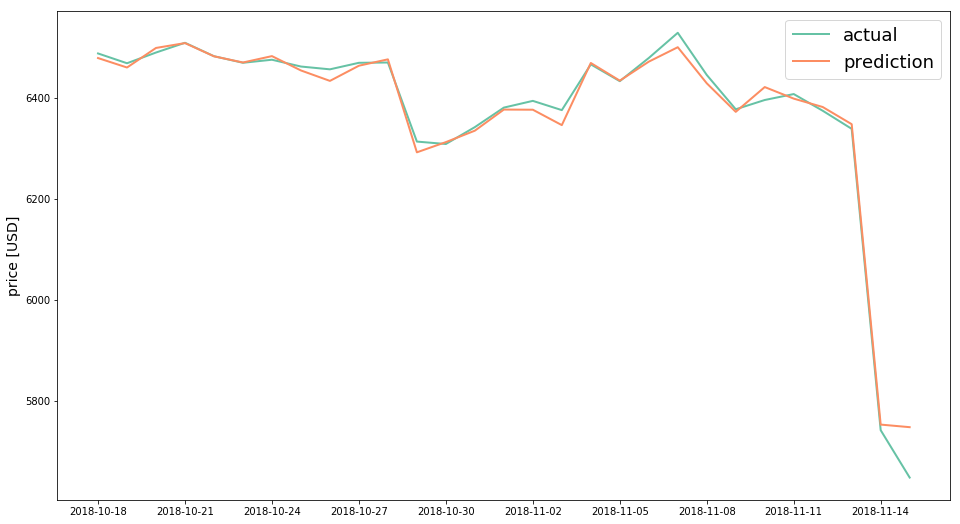

In [25]:
line_plot(targets[-n_points:][:-1], preds[-n_points:].shift(-1), 'actual', 'prediction')

In [26]:
actual_returns = targets.pct_change()[1:] 
predicted_returns = preds.pct_change()[1:]

In [37]:
def dual_line_plot (line1, line2, line3, line4, label1=None, label2=None, title='', lw=2):
    import matplotlib.dates as mdates
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(21, 9))
    ax1.plot(line1, label=label1, linewidth=lw)
    ax1.plot(line2, label=label2, linewidth=lw)
    ax2.plot(line3, label=label1, linewidth=lw)
    ax2.plot(line4, label=label2, linewidth=lw)
    ax2.set_xticks(ax1.get_xticks())
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax1.set_ylabel('daily returns', fontsize=14)
    ax2.legend(loc='best', fontsize=18);

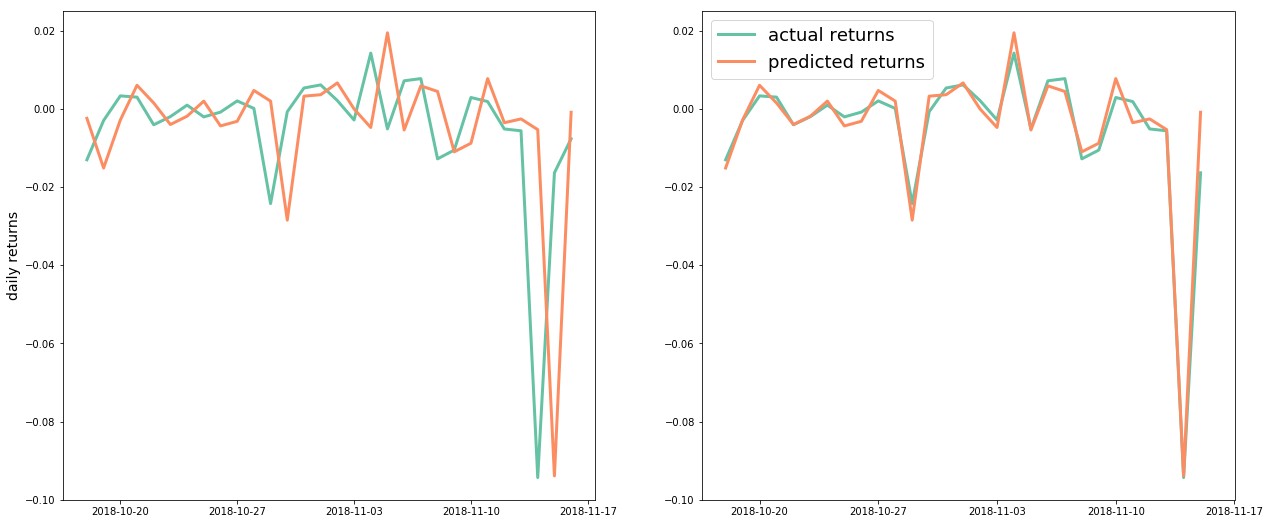

In [38]:
dual_line_plot(actual_returns[-n_points:],
          predicted_returns[-n_points:],
          actual_returns[-n_points:][:-1],
          predicted_returns[-n_points:].shift(-1),
          'actual returns', 'predicted returns', lw=3)

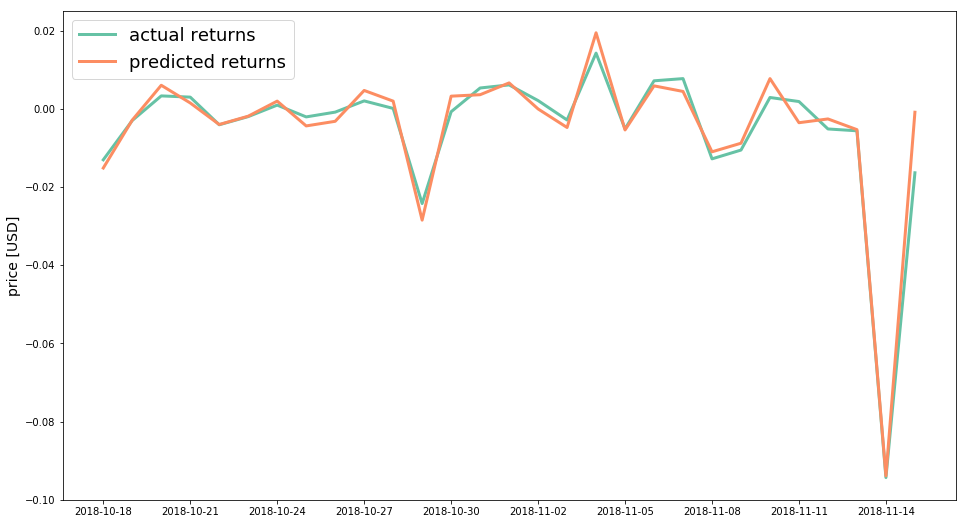

In [33]:
line_plot(actual_returns[-n_points:][:-1], predicted_returns[-n_points:].shift(-1),
           'actual returns', 'predicted returns', lw=3)

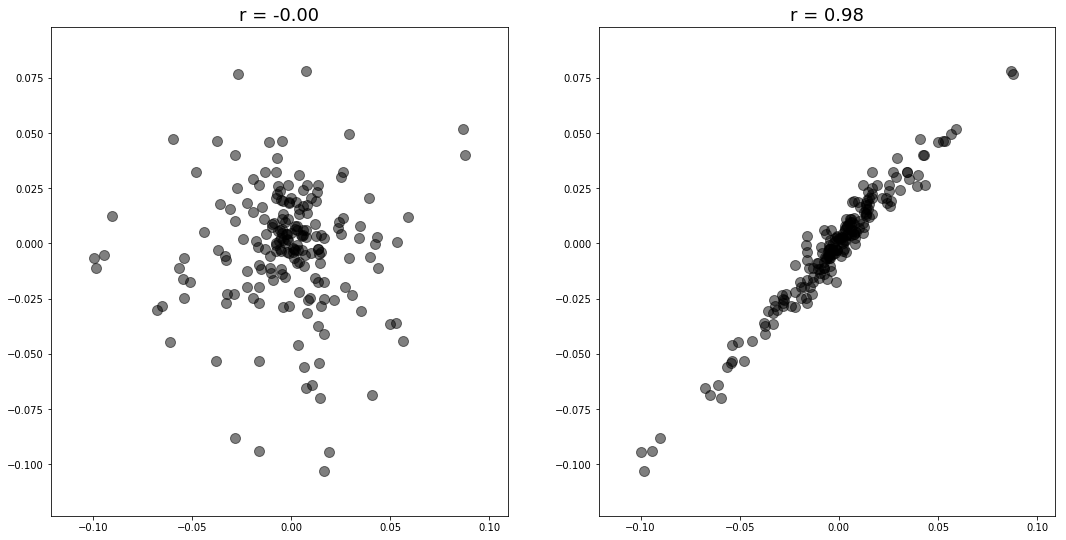

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))

# actual correlation
corr = np.corrcoef(actual_returns, predicted_returns)[0][1]
ax1.scatter(actual_returns, predicted_returns, color='k', marker='o', alpha=0.5, s=100)
ax1.set_title('r = {:.2f}'.format(corr), fontsize=18)

# shifted correlation
shifted_actual = actual_returns[:-1]
shifted_predicted = predicted_returns.shift(-1).dropna()
corr = np.corrcoef(shifted_actual, shifted_predicted)[0][1]
ax2.scatter(shifted_actual, shifted_predicted, color='k', marker='o', alpha=0.5, s=100)
ax2.set_title('r = {:.2f}'.format(corr), fontsize=18);